# White Matter Hyperintensity Segmentation

### Loading Library and Datasets

In [2]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage                                                    
import os
from sklearn.model_selection import train_test_split
import keras
import cv2 as cv
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import pandas as pd

In [2]:
import os
import nibabel as nib
import numpy as np

data_path = "./WMH Dataset/training/Utrecht"
seg_samples = [os.path.join(data_path, sample, "wmh.nii.gz") for sample in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, sample))]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(unique_values)
    
    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")


Maximum number of values in all segmentation images: 3
Values: [0. 1. 2.]


In [ ]:
#import os
#import nibabel as nib
#import numpy as np

data_path = "./WMH Dataset/training/Utrecht"
seg_samples = [os.path.join(data_path, sample, "wmh.nii.gz") for sample in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, sample))]

for sample in seg_samples:
    seg_img = nib.load(sample)
    seg_data = seg_img.get_fdata()

    # Remove class 2 (assuming it's represented by the value 2)
    seg_data[seg_data == 2] = 0

    # Save the modified segmentation data
    modified_seg_img = nib.Nifti1Image(seg_data, seg_img.affine)
    nib.save(modified_seg_img, sample.replace("wmh.nii.gz", "wmh_modified.nii.gz"))


In [19]:
flair = nib.load('./WMH Dataset/training/Utrecht/25/pre/FLAIR.nii.gz').get_fdata()
#flair2 = nib.load('./WML Dataset/Patient-1/1-Flair.nii').get_fdata()
t1 = nib.load('./WMH Dataset/training/Utrecht/25/pre/T1.nii.gz').get_fdata()
#t2 = nib.load('./WML Dataset/Patient-1/1-T2.nii').get_fdata()
seg = nib.load('./WMH Dataset/training/Utrecht/25/wmh.nii.gz').get_fdata()
#segt1 = nib.load('./WML Dataset/Patient-1/1-LesionSeg-T1.nii').get_fdata()
#print(flair.shape)
print(flair.shape)
print(t1.shape)
#print(t2.shape)
print(seg.shape)
#print(segt1.shape)

(240, 240, 48)
(240, 240, 48)
(240, 240, 48)


In [13]:
flair_2 = nib.load('./Laboratory of Imaging/long-MR-MS_patient06-10/patient9/patient9_study2_FLAIRreg.nii.gz').get_fdata()
t1w_2 = nib.load('./Laboratory of Imaging/long-MR-MS_patient06-10/patient9/patient9_study2_T1Wreg.nii.gz').get_fdata()
seg_2 = nib.load('./Laboratory of Imaging/long-MR-MS_patient06-10/patient9/patient9_gt.nii.gz').get_fdata()
print(flair_2.shape)
print(t1w_2.shape)
print(seg_2.shape)

(314, 429, 55)
(314, 429, 55)
(314, 429, 55)


### Displaying MRI image

In [ ]:
for index in range(192):
    img_slice_x = x[:, :, index]
    img_slice_x = (img_slice_x - np.min(x)) / np.ptp(x)
    img_slice_x = np.array(img_slice_x * 255, dtype = np.int8)

    cv.imshow("MRI Image", img_slice_x)
    cv.waitKey(delay = 100)

Text(0.5, 1.0, 'Segmentation Sagittal View')

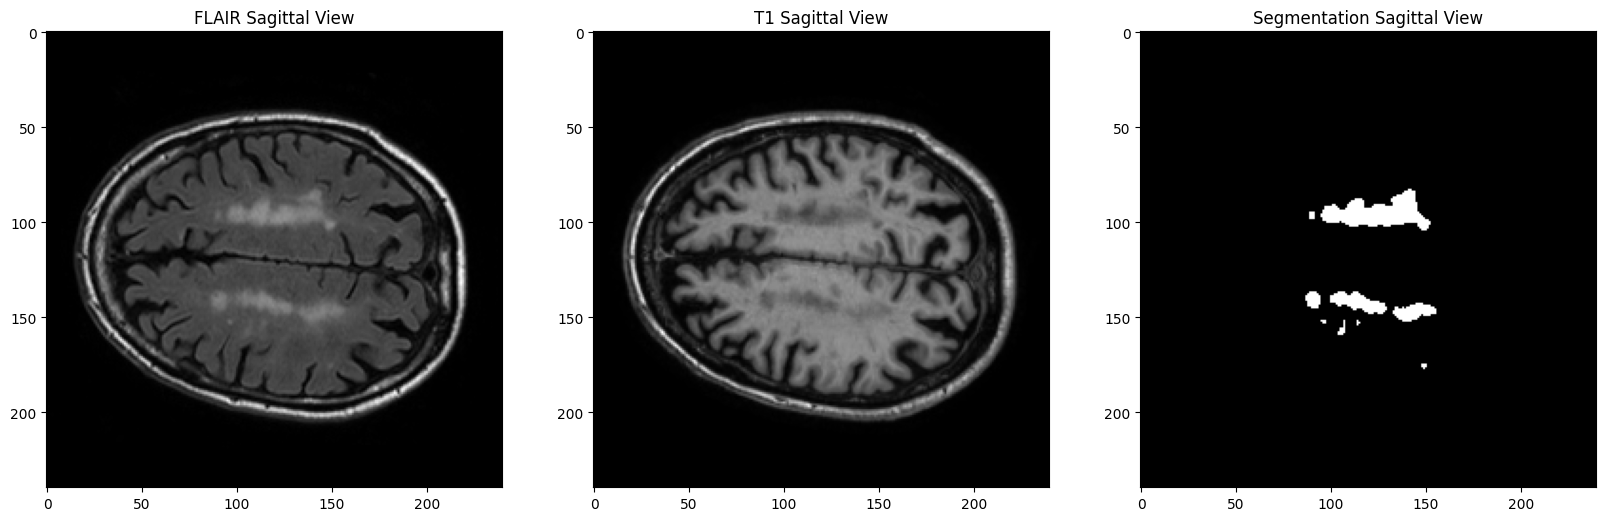

In [30]:
import matplotlib.pyplot as plt
slice_num = 29
fig, axs2 = plt.subplots(1, 3, figsize=(20,20))

axs2[0].imshow(flair[:,:,slice_num], cmap="gray")
axs2[0].set_title('FLAIR Sagittal View')
axs2[1].imshow(t1[:,:,slice_num], cmap="gray")
axs2[1].set_title('T1 Sagittal View')
axs2[2].imshow(seg[:,:,slice_num], cmap="gray")
axs2[2].set_title('Segmentation Sagittal View')

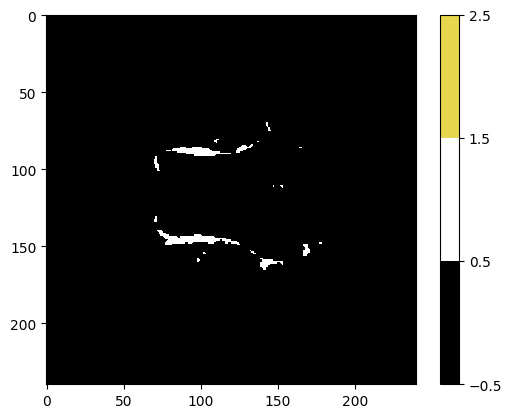

In [2]:
exp_seg = nib.load('./WMH Dataset/training/Utrecht/0/wmh.nii.gz').get_fdata()

cmap = mpl.colors.ListedColormap(['#000000', '#ffffff', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

plt.imshow(exp_seg[:,:,30], cmap=cmap, norm=norm)
plt.colorbar()

In [ ]:
exp_seg = nib.load('./WML Dataset/Patient-1/1-LesionSeg-Flair.nii').get_fdata()

cmap = mpl.colors.ListedColormap(['#000000', '#ffffff', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

plt.imshow(exp_seg[:,:,30], cmap=cmap, norm=norm)
plt.colorbar()

### Preparing data for training

In [ ]:
VOLUME_START_AT = 6
VOLUME_SLICES = 40

In [2]:
base_dir = "WMH Dataset/training/Utrecht"
file_names = ['0', '2', '4', '6', '8', '11', '17', '19', '21', '23', '25', '27', '29',
                '31', '33', '35', '37', '39', '41', '49']
samples = os.listdir(base_dir)
print("Number of samples: ", len(samples))

Number of samples:  20


In [3]:
samples_train, samples_val = train_test_split(samples, test_size=0.15, random_state=42)
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 14
Validation length: 3
Test length: 3


### Generating data for neural network

In [3]:
image_paths = [
    ".\\WMH Dataset\\training\\Utrecht\\0\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\2\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\4\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\6\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\8\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\11\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\17\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\19\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\21\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\23\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\25\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\27\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\29\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\31\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\33\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\35\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\37\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\39\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\41\\orig\\T1.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\49\\orig\\T1.nii.gz",
    # Add more paths as needed
]

seg_paths = [
    ".\\WMH Dataset\\training\\Utrecht\\0\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\2\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\4\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\6\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\8\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\11\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\17\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\19\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\21\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\23\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\25\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\27\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\29\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\31\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\33\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\35\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\37\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\39\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\41\\orig\\wmh.nii.gz",
    ".\\WMH Dataset\\training\\Utrecht\\49\\orig\\wmh.nii.gz",
    # Add more paths as needed
]

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, seg_paths, batch_size=12, image_size=(256, 256), num_slices=48, num_classes=3, shuffle=True):
        self.image_paths = image_paths
        self.seg_paths = seg_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_slices = num_slices
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_image_paths = self.image_paths[start:end]
        batch_seg_paths = self.seg_paths[start:end]

        X, y = self.__data_generation(batch_image_paths, batch_seg_paths)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_image_paths, batch_seg_paths):
        X = np.zeros((self.batch_size, self.num_slices, *self.image_size, 1))
        y = np.zeros((self.batch_size, self.num_slices, *self.image_size, self.num_classes))
        
        for i in range(self.batch_size):
        # Load T1 images
            for j in range(self.num_slices):
                t1_path = batch_image_paths[i]
                t1_img = nib.load(t1_path).get_fdata()
                t1_img = t1_img[:, :, j]
                t1_img = np.expand_dims(t1_img, axis=-1)
                t1_img = tf.image.resize(t1_img, self.image_size)
                X[i, j] = t1_img

        # Load FLAIR images
            for j in range(self.num_slices):
                flair_path = t1_path.replace('T1.nii.gz', 'FLAIR.nii.gz')
                flair_img = nib.load(flair_path).get_fdata()
                flair_img = flair_img[:, :, j]
                flair_img = np.expand_dims(flair_img, axis=-1)
                flair_img = tf.image.resize(flair_img, self.image_size)
                # Assuming that T1 and FLAIR slices are aligned
                X[i, j] = np.concatenate([X[i, j], flair_img], axis=-1)

        # Load segmentation masks
            for j in range(self.num_slices):
                seg_path = batch_seg_paths[i]
                seg = nib.load(seg_path).get_fdata()
                seg = seg[:, :, j]
                seg = tf.one_hot(seg, depth=self.num_classes)
                seg = tf.image.resize(seg, self.image_size)
                y[i, j] = seg

        return X, y

### Define U-Net architecture

In [40]:
from tensorflow.keras import layers, models

def unet(input_size=(256, 256, 1), num_classes=3):
    inputs = tf.keras.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = layers.Dropout(0.1)(conv1)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = layers.Dropout(0.1)(conv2)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = layers.Dropout(0.2)(conv3)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = layers.Dropout(0.2)(conv4)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)

    # Decoder
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat5 = layers.concatenate([conv3, up5], axis=-1)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat5)
    conv5 = layers.Dropout(0.2)(conv5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    concat6 = layers.concatenate([conv2, up6], axis=-1)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat6)
    conv6 = layers.Dropout(0.2)(conv6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    concat7 = layers.concatenate([conv1, up7], axis=-1)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat7)
    conv7 = layers.Dropout(0.1)(conv7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create U-Net model
model = unet()

### Building the model

In [41]:
# Split the dataset into training and validation sets
image_paths_train, image_paths_val, seg_paths_train, seg_paths_val = train_test_split(
    image_paths, seg_paths, test_size=0.2, random_state=42
)

# Create separate DataGenerator instances for training and validation
data_generator_train = DataGenerator(image_paths_train, seg_paths_train, batch_size=batch_size)
data_generator_val = DataGenerator(image_paths_val, seg_paths_val, batch_size=batch_size)

In [42]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,
                                      min_lr=0.000001, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                                    verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger('training.log', separator=',', append=False)
]

### Training and saving the model

In [ ]:
model.fit(training_generator,
          epochs=40,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)

In [ ]:
model.fit(data_generator_train, epochs=20, validation_data=data_generator_val, callbacks=callbacks)